In [1]:

## Importing the required libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [2]:

## Update the location of the data as required 
loc = 'C:/Users/scvch/Documents/Industry_Practicum/Data/'


### Function to read data

In [3]:
## Defining Reading Data function to call later
def reading_data(loc):
    ### Reading the credit related data 
    import pandas as pd
    ## Importing the required libraries
    import pandas as pd
    import numpy as np
    from datetime import datetime
    
    Credit = pd.read_csv(loc + 'Credit balance.txt', sep="\t")
    ## Cleaning the Expiry data column in the data
    Credit['ExpiryDate'] = pd.to_datetime(Credit['ExpiryDate'], format='%d/%m/%Y %H:%M:%S', errors = 'coerce')
    Credit = Credit[~Credit['accountID'].isin([-1,0])]
    Credit['ExpiryDate'] = pd.to_datetime(Credit['ExpiryDate']).dt.date

    ## Reading in the accounts data and using only Active status
    Accounts = pd.read_csv(loc + "Account.txt",sep = "\t")
    Accounts['AccountStatus'].fillna('Active',inplace = True)

    ## Converting date columns to appropriate format
    Accounts['JoinedDate'] = pd.to_datetime(Accounts['JoinedDate']).dt.date
    Accounts['ModifyDate'] = pd.to_datetime(Accounts['ModifyDate']).dt.date

    ## Reading in the account type data and using only Member status
    Account_type = pd.read_csv(loc + "Account Type.txt",sep = "\t")
    Account_type = Account_type[Account_type['BaseType'] == 'MEMBER']

    ## Reading in Accounts Extra Details data and dropping Referral Type and busGrp columns
    Account_extra = pd.read_csv(loc + "Accounts Extra Details.txt",sep = "\t")
    Account_extra = Account_extra.drop(columns = ['ReferralType','busGrp'])

    ## Reading in Account Benefits data, dropping BenefitGrp column, and converting date columns to correct format
    Account_benefits = Account_extra = pd.read_csv(loc + "Account Benefits.txt",sep = "\t")
    Account_benefits = Account_benefits.drop(columns = ['benefitGrp'])
    Account_benefits['utcStartDate'] = pd.to_datetime(Account_benefits['utcStartDate']).dt.date
    Account_benefits['utcEndDate'] = pd.to_datetime(Account_benefits['utcEndDate']).dt.date

    ## Reading in Ownership data and dropping AnniversaryDate and ExpiryDate
    Ownership = pd.read_csv(loc + "Ownership.txt",sep = "\t")
    Ownership = Ownership.drop(columns = ['AnniversaryDate','expiryDate'])




    ## Reading in Resort Details data, dropping different Id and other columsn and converting updatedDate to appropriate format
    resort = pd.read_csv(loc + "Resort Details.txt",sep = "\t")
    resort = resort.drop(columns = ['territoryId','territory','AccountId','mapDestOfficeKey','busDevUserId','busDevUser','daeOptions','excludeFromAvailability'])
    resort['updatedDate'] = pd.to_datetime(resort['updatedDate']).dt.date



    # Reading in Resort Other Attributes data
    resort_oth_attr = pd.read_csv(loc + "Resort Other Attributes.txt",sep = "\t")
    #resort_attr = resort_attr.drop(columns = ['AttrID'])
    #resort_attr = resort_attr.groupby(['ResortID','AttrType']).count().reset_index()
    #resort_attr['updatedDate'] = pd.to_datetime(resort_attr['updatedDate']).dt.date

    # Reading in Attributes data
    resort_attr = pd.read_csv(loc + "Attributes.txt",sep = "\t")




    # Reading in Inventory Data using Exchange Status for 'SuppliedAs', member status for purchaserbasetype, and coverting date to appropriate format
    Inventory = pd.read_csv(loc + "Inventory.txt",sep = "\t")
    Inventory = Inventory[Inventory['suppliedAs'] == 'Exchange']
    Inventory = Inventory[Inventory['purchaserbaseType'] == 'MEMBER']
    Inventory['depositDate'] = pd.to_datetime(Inventory['depositDate']).dt.date
    #resort = resort.drop(columns = ['territoryId','territory','AccountId','mapDestOfficeKey','busDevUserId','busDevUser','daeOptions','excludeFromAvailability'])
    #resort['updatedDate'] = pd.to_datetime(resort['updatedDate']).dt.date

    # Reading in Transactions data, converting data columns to appropriate format
    Transactions = pd.read_csv(loc + "Transactions.txt",sep = "\t",low_memory = False)
    Transactions['txnDate'] = pd.to_datetime(Transactions['txnDate'])
    Transactions['bookDate'] = pd.to_datetime(Transactions['bookDate'])
    Transactions['cancelDate'] = pd.to_datetime(Transactions['cancelDate'])
    Transactions['startDate'] = pd.to_datetime(Transactions['startDate'])
    Transactions['endDate'] = pd.to_datetime(Transactions['endDate'])


    ### Events table skipped for now
    ## Reading in Events data and converting to date format
    Events = pd.read_csv(loc + "Events.txt",sep = "\t")
    Events['EventTimestamp'] = pd.to_datetime(Events['EventTimestamp']).dt.date
    #Events['ModifyDate'] = pd.to_datetime(Events['ModifyDate']).dt.date
    #Events['JoinedDate'] = pd.to_datetime(Events['JoinedDate']).dt.date


    ## COnverting EventTimestamp in Events table to appropriate format
    Event_sep_2021 = Events[Events['EventTimestamp'] <= datetime.strptime('2021-09-01',"%Y-%m-%d").date()]
    #Events = pd.read_csv(loc + "Events.txt",sep = "\t",low_memory = False,skiprows = 1000000,nrows = 3000000)


    #Events['Member Search Availability'].unique()
    #Events[Events['Purchased Something'] == 'Member Search Availability']

    #pd.read_csv(loc + "Events.txt",sep = "\t",low_memory = False,nrows = 30)


    ## Reading in Requests data and converting to date format
    Requests = pd.read_csv(loc + "Requests.txt",sep = "\t")
    Requests['RequestDate'] = pd.to_datetime(Requests['RequestDate']).dt.date

    # Reading in Request Resorts data
    Request_Resorts = pd.read_csv(loc + "Request Resorts.txt",sep = "\t")


    # Reading in Request Offers data and converting to appropriate date format
    Request_offers = pd.read_csv(loc + "Request Offers.txt",sep = "\t")
    Request_offers['OfferDate'] = pd.to_datetime(Request_offers['OfferDate']).dt.date

    return Credit, Accounts, Account_type, Account_extra, Account_benefits, Ownership, resort, resort_oth_attr, resort_attr,Inventory,Transactions, Events,Requests, Request_Resorts, Request_offers



### Data Setup

In [4]:
## Defining Data Setup function to call later
def data_setup(train_start_date,season_length,num_seasons_to_consider,loc,Credit, Accounts, Account_type, Account_extra, Account_benefits, Ownership, resort, resort_oth_attr, resort_attr,Inventory,Transactions, Events,Requests, Request_Resorts, Request_offers):
    for i in range(num_seasons_to_consider):
    ## Creating s for offsetting by 3 months, reading in Account data, converting to date formats, and inner joining with AccountType data
        s = datetime.strptime(train_start_date,"%Y-%m-%d").date() - i*pd.DateOffset(months = season_length)
        s = s.date()
        Accounts = pd.read_csv(loc + "Account.txt",sep = "\t")
        Accounts['AccountStatus'].fillna('Active',inplace = True)
        Accounts['JoinedDate'] = pd.to_datetime(Accounts['JoinedDate']).dt.date
        Accounts['ModifyDate'] = pd.to_datetime(Accounts['ModifyDate']).dt.date
        Accounts = pd.merge(Accounts,Account_type,on = 'AccountType',how = 'inner')
        
    ## Including Joined date and membership days columns for appropriate time period and using Active status only
        Accounts = Accounts[Accounts['JoinedDate'] < s] 
        Accounts['Membership days'] = s - Accounts['ModifyDate']  
        Accounts['Membership days'] = Accounts['Membership days'].dt.days
        Accounts = Accounts[Accounts['AccountStatus'] == 'Active']

    ## Reduced utcEndDate by 3 months
        paid_members = Account_benefits[Account_benefits['utcEndDate'] >= s - pd.DateOffset(months=3) ]
        paid_members['gold_member'] = 1
        paid_members = paid_members[['AccountID','gold_member']]
    ## Joining Accounts and paid_members data and accordingly filling null values and dropping unecessary columns
        Accounts = pd.merge(Accounts,paid_members,how = 'left',left_on = 'accountid',right_on = 'AccountID')
        Accounts['gold_member'].fillna(0,inplace = True)
        Accounts = Accounts.drop(columns = ['AccountID'])

    ## Calculated number of ownerships, and merged with Accounts data and dropped unecessary columns
        num_ownerships = Ownership[['AccountID','ownershipNo']].groupby('AccountID').max('ownershipNo').reset_index()
        Accounts = pd.merge(Accounts,num_ownerships,how = 'left',left_on = 'accountid',right_on = 'AccountID')
        Accounts = Accounts.drop(columns = ['AccountID'])

    ## Calculated new credit expiry date and days_to_expiry accounting for appropriate season length, got num_days_to_expiry, and then merged with Accounts data
        Credit_new = Credit[Credit['ExpiryDate'] >= s ]
        Credit_new['days_to_expiry'] = Credit_new['ExpiryDate'] - s
        Credit_new['days_to_expiry'] = Credit_new['days_to_expiry'].dt.days
        num_days_to_expiry = Credit_new[['accountID','days_to_expiry']].groupby('accountID').min().reset_index()
        Accounts = pd.merge(Accounts,num_days_to_expiry,how = 'left',left_on = 'accountid',right_on = 'accountID')
        Accounts = Accounts.drop(columns = ['accountID'])



    ## days_since_deposited calculated, and merged with Accounts data, dropping unecessary columns
        Inventory['depositId'] = Inventory['depositId'].astype('float')

        Inventory_new = Inventory[Inventory['depositDate'] < s]
        Inventory_new['days_since_deposit'] = s - Inventory_new['depositDate']
        Inventory_new['days_since_deposit'] = Inventory_new['days_since_deposit'].dt.days
        days_since_last_deposit = Inventory_new[['accountId','days_since_deposit']].groupby('accountId').min('days_since_deposit').reset_index()
        Accounts = pd.merge(Accounts,days_since_last_deposit,how = 'left',left_on = 'accountid',right_on = 'accountId')
        Accounts = Accounts.drop(columns = ['accountId'])


    ## number of bookings calculated, merged with Accounts data, and filled in null values according to a 12 month period
        number_of_book = Transactions[(Transactions['txnDate'].dt.date > s-pd.DateOffset(months=12) ) & (Transactions['txnDate'].dt.date < s)].groupby('accountId').count()[['bookDate','cancelDate']].reset_index()
        number_of_book.columns = ['accountId','no_bookings_12_months','no_cancels_12_months']
        Accounts = pd.merge(Accounts,number_of_book ,how = 'left',left_on = 'accountid',right_on = 'accountId')
        Accounts = Accounts.drop(columns = ['accountId'])
        Accounts['no_bookings_12_months'].fillna(0,inplace = True)
        Accounts['no_cancels_12_months'].fillna(0,inplace = True)


    ## number of bookings calculated, merged with Accounts data, and filled in null values according to a 6 month period
        number_of_book = Transactions[(Transactions['txnDate'].dt.date > s-pd.DateOffset(months=6) ) & (Transactions['txnDate'].dt.date < s)].groupby('accountId').count()[['bookDate','cancelDate']].reset_index()
        number_of_book.columns = ['accountId','no_bookings_6_months','no_cancels_6_months']
        Accounts = pd.merge(Accounts,number_of_book ,how = 'left',left_on = 'accountid',right_on = 'accountId')
        Accounts = Accounts.drop(columns = ['accountId'])
        Accounts['no_bookings_6_months'].fillna(0,inplace = True)
        Accounts['no_bookings_6_months'].fillna(0,inplace = True)




    ## Creating Account_Members and Event_Members tables by inner joining requisite tables
        Account_Members = pd.merge(Accounts,Account_type,how = 'inner',left_on = 'AccountType',right_on = 'AccountType')[["accountid"]]
        Event_Members = pd.merge(Account_Members,Events,how = 'inner',left_on = 'accountid',right_on = 'AccountID')


    ## Finding number of requests in past season with 3 month offsetting
        Event_Members_s8 = Event_Members[(Event_Members['EventTimestamp'] > s-pd.DateOffset(months=3)) & (Event_Members['EventTimestamp'] <= s)]

        no_of_requests = Event_Members_s8[Event_Members_s8['eventName']=='Member Request Placed']
        no_of_requests = no_of_requests[['accountid','RequestID']].groupby('accountid').count().reset_index()
        no_of_requests.rename(columns={'RequestID': 'no_requests_in_3_months'},inplace = True)    
        no_of_member_search = Event_Members_s8[Event_Members_s8['eventName']=='Member Search Availability']
        no_of_member_search = no_of_member_search[['accountid','RequestID']].groupby('accountid').count().reset_index()
        no_of_member_search.rename(columns={'RequestID': 'no_searches_in_3_months'},inplace = True)
        Accounts= pd.merge(Accounts,no_of_member_search ,how = 'left',on = 'accountid')
        Accounts= pd.merge(Accounts,no_of_requests ,how = 'left',on = 'accountid')

    ## Finding number of requests in past season with 6 month offsetting
        Event_Members_s8 = Event_Members[(Event_Members['EventTimestamp'] > s-pd.DateOffset(months=6)) & (Event_Members['EventTimestamp'] <= s)]

        no_of_requests = Event_Members_s8[Event_Members_s8['eventName']=='Member Request Placed']
        no_of_requests = no_of_requests[['accountid','RequestID']].groupby('accountid').count().reset_index()
        no_of_requests.rename(columns={'RequestID': 'no_requests_in_6_months'},inplace = True)    
        no_of_member_search = Event_Members_s8[Event_Members_s8['eventName']=='Member Search Availability']
        no_of_member_search = no_of_member_search[['accountid','RequestID']].groupby('accountid').count().reset_index()
        no_of_member_search.rename(columns={'RequestID': 'no_searches_in_6_months'},inplace = True)
        Accounts= pd.merge(Accounts,no_of_member_search ,how = 'left',on = 'accountid')
        Accounts= pd.merge(Accounts,no_of_requests ,how = 'left',on = 'accountid')

    ## Finding number of requests in past season with 12 month offsetting
        Event_Members_s8 = Event_Members[(Event_Members['EventTimestamp'] > s-pd.DateOffset(months=12)) & (Event_Members['EventTimestamp'] <= s)]

        no_of_requests = Event_Members_s8[Event_Members_s8['eventName']=='Member Request Placed']
        no_of_requests = no_of_requests[['accountid','RequestID']].groupby('accountid').count().reset_index()
        no_of_requests.rename(columns={'RequestID': 'no_requests_in_12_months'},inplace = True)    
        no_of_member_search = Event_Members_s8[Event_Members_s8['eventName']=='Member Search Availability']
        no_of_member_search = no_of_member_search[['accountid','RequestID']].groupby('accountid').count().reset_index()
        no_of_member_search.rename(columns={'RequestID': 'no_searches_in_12_months'},inplace = True)
        Accounts= pd.merge(Accounts,no_of_member_search ,how = 'left',on = 'accountid')
        Accounts= pd.merge(Accounts,no_of_requests ,how = 'left',on = 'accountid')


    ## Finding number of canceled offers in past season with 3 months offsetting
        num_canceled_offers = Request_offers[(Request_offers['OfferDate'] > s- pd.DateOffset(months=3)) & (Request_offers['OfferStatus'] == 'CANCELLED') & (Request_offers['OfferDate'] < s)].groupby('RequestID').count().reset_index()
        num_canceled_offers = num_canceled_offers[['RequestID','OfferID']]
        num_canceled_offers.columns = ['RequestID','num_offers_cancelled']
        num_canceled_offers = Requests[['AccountID','RequestID']].merge(num_canceled_offers,on = 'RequestID')
        num_canceled_offers.rename(columns={'num_offers_cancelled': 'num_offers_cancelled_3_months'},inplace = True)
        Accounts= pd.merge(Accounts,num_canceled_offers ,how = 'left',left_on = 'accountid',right_on = 'AccountID')
        Accounts = Accounts.drop(columns = ['AccountID'])
        Accounts = Accounts.drop(columns = ['RequestID'])

    ## Finding number of canceled offers in past season with 6 months offsetting
        num_canceled_offers = Request_offers[(Request_offers['OfferDate'] > s- pd.DateOffset(months=6)) & (Request_offers['OfferStatus'] == 'CANCELLED') & (Request_offers['OfferDate'] < s)].groupby('RequestID').count().reset_index()
        num_canceled_offers = num_canceled_offers[['RequestID','OfferID']]
        num_canceled_offers.columns = ['RequestID','num_offers_cancelled']
        num_canceled_offers = Requests[['AccountID','RequestID']].merge(num_canceled_offers,on = 'RequestID')
        num_canceled_offers.rename(columns={'num_offers_cancelled': 'num_offers_cancelled_6_months'},inplace = True)
        Accounts= pd.merge(Accounts,num_canceled_offers ,how = 'left',left_on = 'accountid',right_on = 'AccountID')
        Accounts = Accounts.drop(columns = ['AccountID'])
        Accounts = Accounts.drop(columns = ['RequestID'])

    ## Finding number of canceled offers in past season with 12 months offsetting
        num_canceled_offers = Request_offers[(Request_offers['OfferDate'] > s- pd.DateOffset(months=12)) & (Request_offers['OfferStatus'] == 'CANCELLED') & (Request_offers['OfferDate'] < s)].groupby('RequestID').count().reset_index()
        num_canceled_offers = num_canceled_offers[['RequestID','OfferID']]
        num_canceled_offers.columns = ['RequestID','num_offers_cancelled']
        num_canceled_offers = Requests[['AccountID','RequestID']].merge(num_canceled_offers,on = 'RequestID')
        num_canceled_offers.rename(columns={'num_offers_cancelled': 'num_offers_cancelled_12_months'},inplace = True)
        Accounts= pd.merge(Accounts,num_canceled_offers ,how = 'left',left_on = 'accountid',right_on = 'AccountID')
        Accounts = Accounts.drop(columns = ['AccountID'])
        Accounts = Accounts.drop(columns = ['RequestID'])


    ## Calculating Events for season 9 accordingly, dropping duplicatesand setting response to 1 accordingly
        Events_s9 = Event_Members[(Event_Members['EventTimestamp'] > s) & (Event_Members['EventTimestamp'] < s + pd.DateOffset(months=3)) ]
        Events_s9 = Events_s9[Events_s9['eventName']=='Purchased Something'].drop_duplicates()
        Events_s9['response'] = 1 

    ## dropping duplicates from all Event_members accounts and Events_s9 accounts
        all_accounts = Event_Members[['accountid']].drop_duplicates()
        response = Events_s9[['accountid','response']].drop_duplicates()

    ## merging all_accounts and response tables and cleaning up data accordingly
        response = pd.merge(all_accounts,response,how = 'left',left_on = 'accountid',right_on = 'accountid')
        response['response'].fillna(0,inplace = True)
        response['response']= response['response'].astype(int)

    ## Inner joining Accounts with Response tables
        Accounts = pd.merge(Accounts,response,on = 'accountid',how = 'inner') 

        if i==0 :
            dt = Accounts
        else:
            dt = pd.concat([dt, Accounts], ignore_index=True, sort=False)
        
    return dt


## Data Visualisation

In [5]:
def Visualize_data(Master_data,bins):
    Master_data = Master_data[Master_data['Membership days'] > 0]
    Master_data = Master_data.drop(columns = ['JoinedDate','ModifyDate','Description','AccountStatus'])
    Master_data = pd.get_dummies(Master_data)
    for i in Master_data.columns[2:-7].to_list():
        print(i)
        ## Creating data tables with resetting index for account data, creating bins, and renaming appropriate columns
        dt_new = Master_data.reset_index()[['accountid',i]].groupby(i).count().reset_index()      
        dt_new['bins'] = pd.cut(x = dt_new[i],bins = bins )
        dt_new.rename(columns={'accountid': 'count_of_accounts'},inplace = True)
        dt_new = dt_new[['count_of_accounts','bins']]
        
        ## Creating data tables with resetting index for response data, creating bins, and renaming appropriate columns
        dt_new_2 = Master_data.reset_index()[['response',i]].groupby(i).sum().reset_index()
        dt_new_2['bins'] = pd.cut(x = dt_new_2[i],bins = bins )
        dt_new_2.rename(columns={'response': 'response_of_accounts'},inplace = True)
        dt_new_2 = dt_new_2[['response_of_accounts','bins']]
        dt3 = pd.merge(dt_new,dt_new_2,on = 'bins')
        dt3 = dt3.groupby('bins').sum()
        #dt3['count_of_accounts'].astype(int,inplace = True)
        #dt3['response_of_accounts'].astype(int,inplace = True)
        dt3['percentage_of_response'] = dt3['response_of_accounts']/dt3['count_of_accounts']
        dt3 = dt3.reset_index()
        dt3['bins'] = dt3['bins'].astype(str)

        # create figure and axis objects with subplots()
        fig,ax = plt.subplots()
        # make a plot
        plt.grid(color='black', linestyle='-', linewidth=0.1)
        ax.bar(dt3['bins'], dt3['count_of_accounts'], color="blue", width=0.1)
        # set x-axis label
        ax.set_xlabel(i+"_bins",fontsize=14)
        # set y-axis label
        ax.set_ylabel("count of accounts",color="red",fontsize=14)
        # twin object for two different y-axis on the sample plot
        ax2=ax.twinx()
        # make a plot with different y-axis using second axis object
        ax2.plot(dt3['bins'], dt3["percentage_of_response"],color="black",marker="o")
        ax2.set_ylabel("count of bookings",color="blue",fontsize=14)
        plt.show()

### Data Prep for Modelling

In [6]:
def model_data_prep(Master_data):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    ## Dropping the unnecessary columns from the data
    Master_data = Master_data[Master_data['Membership days'] > 0]
    Master_data = Master_data.drop(columns = ['JoinedDate','ModifyDate','Description','AccountStatus'])
    Master_data = pd.get_dummies(Master_data)
    ### Seperating response variable dataset and Factors data set

    Master_data = Master_data.set_index('accountid')
    Y = Master_data['response']
    X =  Master_data.drop(columns = ['response'])
    X.fillna(0,inplace = True)
    
    training_x, testing_x, training_c, testing_c = train_test_split(X, Y, test_size=0.2, random_state= 8)
    training_x, valid_x, training_c, valid_c = train_test_split(training_x, training_c, test_size=0.25, random_state= 8)
    
    return training_x, valid_x, training_c, valid_c, testing_x, testing_c

## Undersampling

In [7]:
def undersampling_data(training_x,training_c):
    # example of random undersampling to balance the class distribution
    from collections import Counter
    from sklearn.datasets import make_classification
    from imblearn.under_sampling import RandomUnderSampler

    # define undersample strategy
    undersample = RandomUnderSampler(sampling_strategy='majority')
    # fit and apply the transform
    X_over, y_over = undersample.fit_resample(training_x, training_c)
    # summarize class distribution
    return X_over, y_over

### Logistic Regression

In [8]:
def log_reg(training_x,training_c,valid_x,valid_c):
    from sklearn.linear_model import LogisticRegression 
    Logitmodel = LogisticRegression()
    # training logistic regression model
    Logitmodel.fit(training_x, training_c)
    #y_pred_logit = Logitmodel.predict(testing_x)
    ## Calculating and displaying Logistic Regression model Accuracy
    y_pred_logit = Logitmodel.predict(valid_x)
    acc_logit = accuracy_score(valid_c, y_pred_logit)   

    fpr, tpr, thresholds = roc_curve(y_true=list(valid_c), y_score=list(y_pred_logit))
    auc = roc_auc_score(y_true=list(valid_c), y_score=list(y_pred_logit))
    
    return acc_logit, auc, Logitmodel

### Decision Tree

In [9]:
def dec_tree(training_x,training_c,valid_x,valid_c):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn import tree

    ## Calculating Decision Tree and displaying accuracy
    DTmodel = DecisionTreeClassifier()
    DTmodel.fit(training_x, training_c)
    y_pred_dec = DTmodel.predict(valid_x)
    acc_dec = accuracy_score(valid_c, y_pred_dec)
    
    
    fpr, tpr, thresholds = roc_curve(y_true=list(valid_c), y_score=list(y_pred_dec))
    auc = roc_auc_score(y_true=list(valid_c), y_score=list(y_pred_dec))
    
    ## Obtaining importance of different factors in Decision Tree model, sorted accordingly
    DTmodel.feature_importances_
    sorted_idx = DTmodel.feature_importances_.argsort()
    plt.barh(training_x.columns[sorted_idx][-10:], DTmodel.feature_importances_[sorted_idx][-10:])
    return acc_dec, auc, DTmodel

### Random Forest

In [10]:
def Random_forest(training_x,training_c,valid_x,valid_c):
    from sklearn.ensemble import RandomForestClassifier
    ##Creating Random Forest model and displaying accuracy
    RFmodel = RandomForestClassifier(n_estimators=200, max_depth=10,bootstrap=True, random_state=1) ## number of trees and number of layers/depth

    RFmodel.fit(training_x, training_c)
    y_pred_RF = RFmodel.predict(valid_x)
    acc_RF = accuracy_score(valid_c, y_pred_RF)
    
    
    ## Sorting importance of different factors in Random Forest model
    RFmodel.feature_importances_

    sorted_idx = RFmodel.feature_importances_.argsort()

    plt.barh(training_x.columns[sorted_idx][-10:], RFmodel.feature_importances_[sorted_idx][-10:])
    
    ## obtaining AUC value of Random Forest Model
    fpr, tpr, thresholds = roc_curve(y_true=list(valid_c), y_score=list(y_pred_RF))
    auc = roc_auc_score(y_true=list(valid_c), y_score=list(y_pred_RF))
    return acc_RF, auc, RFmodel



## Gradient Boosting

In [11]:
def grad_boost(training_x,training_c,valid_x,valid_c):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from xgboost import plot_importance
    from matplotlib import pyplot as plt
    
    # fit the model on the whole dataset
    model = GradientBoostingClassifier(max_depth = 3)
    model.fit(training_x, training_c)

    # obtaining and printing Gradient Boosting Model Accuracy
    y_pred_boost = model.predict(valid_x)
    acc_boost = accuracy_score(valid_c, y_pred_boost)
    
    ## Sorting importance of different factors in Gradient Boosting model
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(training_x.columns[sorted_idx][-10:], model.feature_importances_[sorted_idx][-10:])

    # Printing AUC value
    fpr, tpr, thresholds = roc_curve(y_true=list(valid_c), y_score=list(y_pred_boost))
    auc = roc_auc_score(y_true=list(valid_c), y_score=list(y_pred_boost))
    
    return acc_boost, auc, model

## Neural Network

In [12]:
def neural_network (training_x,training_c,valid_x,valid_c,testing_x, testing_c):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import time
    from sklearn import metrics
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.datasets import mnist

    #from keras.layers import Dropout 

    model = keras.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(26,)))
    model.add(layers.Dense(1024, activation='relu')) 
    model.add(layers.Dense(128, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(0.0015),metrics=['accuracy'])
    
    ## Training neural network with appropriate parameters to balance models
    EPOCHS = 20

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


    history = model.fit(training_x, training_c,
                        batch_size=128, epochs=EPOCHS,
                        validation_data=(valid_x, valid_c),
                        callbacks=[early_stop])
    
    # Obtaining AUC and plotting ROC curve
    y_pred = model.predict(testing_x).ravel()    
    nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(testing_c, y_pred)
    auc_keras = metrics.auc(nn_fpr_keras, nn_tpr_keras)
    plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
    
    return auc_keras,model

## Running the models

In [13]:
def run_machine_learning_models (training_x, training_c, valid_x, valid_c, testing_x, testing_c):
    
    logit_acc,logit_auc, logit_model = log_reg(training_x,training_c,valid_x,valid_c)
    print("Logistic regresssion Accuracy:: {:.2f}%".format(logit_acc*100))
    print("Logistic regression roc :: {:.2f}%:".format(logit_auc))


    decision_tree_acc,decision_tree_auc, dt_model = dec_tree(training_x,training_c,valid_x,valid_c)
    print("Decision Tree Accuracy:: {:.2f}%".format(decision_tree_acc*100))
    print("Decision Tree AUC:: {:.2f}%".format(decision_tree_auc))



    acc_RF, auc_RF, RF_model = Random_forest(training_x,training_c,valid_x,valid_c)
    print("Random Forest Accuracy:: {:.2f}%".format(acc_RF*100))
    print("Random Forest AUC:: {:.2f}%".format(auc_RF))



    acc_boost, auc_boost, xg_model = grad_boost(training_x,training_c,valid_x,valid_c)
    print("Xg boost model Accuracy:: {:.2f}%".format(acc_boost*100))
    print("Xg boost model Auc:: {:.2f}%".format(auc_boost))

    NN_auc, DNN_model = neural_network (training_x,training_c,valid_x,valid_c,testing_x, testing_c)
    print("DNN model Auc:: {:.2f}%".format(NN_auc))
    
    model_performances = [logit_auc,decision_tree_auc,auc_RF,auc_boost,NN_auc]
    models = [logit_model,dt_model,RF_model,xg_model,DNN_model]
    
    min_roc = max(model_performances)
    best_model_index = model_performances.index(min_roc)
    
    best_model = models[best_model_index]
    print('best model is:',models[best_model_index])
    
    return best_model

### prediction data pipline

In [14]:
def data_predict(prediction_start_date,Credit, Accounts, Account_type, Account_extra, Account_benefits, Ownership, resort, resort_oth_attr, resort_attr,Inventory,Transactions, Events,Requests, Request_Resorts, Request_offers ):
    
    # Setting up Data for Predicting Next Season
    s = datetime.strptime(prediction_start_date,"%Y-%m-%d").date() 
    
    # Reading in Account data and setting up accordingly
    Accounts = pd.read_csv(loc + "Account.txt",sep = "\t")
    Accounts['AccountStatus'].fillna('Active',inplace = True)
    Accounts['JoinedDate'] = pd.to_datetime(Accounts['JoinedDate']).dt.date
    Accounts['ModifyDate'] = pd.to_datetime(Accounts['ModifyDate']).dt.date
    Accounts = pd.merge(Accounts,Account_type,on = 'AccountType',how = 'inner')

    ## Including Joined date and membership days columns for appropriate time period and using Active status only
    Accounts = Accounts[Accounts['JoinedDate'] < s] 
    Accounts['Membership days'] = s - Accounts['ModifyDate']  
    Accounts['Membership days'] = Accounts['Membership days'].dt.days
    Accounts = Accounts[Accounts['AccountStatus'] == 'Active']

    ## Reduced utcEndDate by 3 months
    paid_members = Account_benefits[Account_benefits['utcEndDate'] >= s - pd.DateOffset(months=3) ]
    paid_members['gold_member'] = 1
    paid_members = paid_members[['AccountID','gold_member']]

    ## Joining Accounts and paid_members data and accordingly filling null values and dropping unecessary columns
    Accounts = pd.merge(Accounts,paid_members,how = 'left',left_on = 'accountid',right_on = 'AccountID')
    Accounts['gold_member'].fillna(0,inplace = True)
    Accounts = Accounts.drop(columns = ['AccountID'])

    ## Calculated number of ownerships, and merged with Accounts data and dropped unecessary columns
    num_ownerships = Ownership[['AccountID','ownershipNo']].groupby('AccountID').max('ownershipNo').reset_index()
    Accounts = pd.merge(Accounts,num_ownerships,how = 'left',left_on = 'accountid',right_on = 'AccountID')
    Accounts = Accounts.drop(columns = ['AccountID'])

    ## Calculated new credit expiry date and days_to_expiry accounting for appropriate season length, got num_days_to_expiry, and then merged with Accounts data
    Credit_new = Credit[Credit['ExpiryDate'] >= s ]
    Credit_new['days_to_expiry'] = Credit_new['ExpiryDate'] - s
    Credit_new['days_to_expiry'] = Credit_new['days_to_expiry'].dt.days
    num_days_to_expiry = Credit_new[['accountID','days_to_expiry']].groupby('accountID').min().reset_index()
    Accounts = pd.merge(Accounts,num_days_to_expiry,how = 'left',left_on = 'accountid',right_on = 'accountID')
    Accounts = Accounts.drop(columns = ['accountID'])



    ## days_since_deposited calculated, and merged with Accounts data, dropping unecessary columns
    Inventory['depositId'] = Inventory['depositId'].astype('float')
    Inventory_new = Inventory[Inventory['depositDate'] < s]
    Inventory_new['days_since_deposit'] = s - Inventory_new['depositDate']
    Inventory_new['days_since_deposit'] = Inventory_new['days_since_deposit'].dt.days
    days_since_last_deposit = Inventory_new[['accountId','days_since_deposit']].groupby('accountId').min('days_since_deposit').reset_index()
    Accounts = pd.merge(Accounts,days_since_last_deposit,how = 'left',left_on = 'accountid',right_on = 'accountId')
    Accounts = Accounts.drop(columns = ['accountId'])


    ## number of bookings calculated according to a 12 month period
    number_of_book = Transactions[(Transactions['txnDate'].dt.date > s-pd.DateOffset(months=12) ) & (Transactions['txnDate'].dt.date < s)].groupby('accountId').count()[['bookDate','cancelDate']].reset_index()
    number_of_book.columns = ['accountId','no_bookings_12_months','no_cancels_12_months']
    Accounts = pd.merge(Accounts,number_of_book ,how = 'left',left_on = 'accountid',right_on = 'accountId')
    Accounts = Accounts.drop(columns = ['accountId'])
    Accounts['no_bookings_12_months'].fillna(0,inplace = True)
    Accounts['no_cancels_12_months'].fillna(0,inplace = True)


    ## number of bookings calculated according to a 6 month period
    number_of_book = Transactions[(Transactions['txnDate'].dt.date > s-pd.DateOffset(months=6) ) & (Transactions['txnDate'].dt.date < s)].groupby('accountId').count()[['bookDate','cancelDate']].reset_index()
    number_of_book.columns = ['accountId','no_bookings_6_months','no_cancels_6_months']
    Accounts = pd.merge(Accounts,number_of_book ,how = 'left',left_on = 'accountid',right_on = 'accountId')
    Accounts = Accounts.drop(columns = ['accountId'])
    Accounts['no_bookings_6_months'].fillna(0,inplace = True)
    Accounts['no_bookings_6_months'].fillna(0,inplace = True)




    ## Creating Account_Members and Event_Members tables by inner joining requisite tables
    Account_Members = pd.merge(Accounts,Account_type,how = 'inner',left_on = 'AccountType',right_on = 'AccountType')[["accountid"]]
    Event_Members = pd.merge(Account_Members,Events,how = 'inner',left_on = 'accountid',right_on = 'AccountID')


    ## Finding number of requests in past season with 3 month offsetting
    Event_Members_s8 = Event_Members[(Event_Members['EventTimestamp'] > s-pd.DateOffset(months=3)) & (Event_Members['EventTimestamp'] <= s)]

    no_of_requests = Event_Members_s8[Event_Members_s8['eventName']=='Member Request Placed']
    no_of_requests = no_of_requests[['accountid','RequestID']].groupby('accountid').count().reset_index()
    no_of_requests.rename(columns={'RequestID': 'no_requests_in_3_months'},inplace = True)    
    no_of_member_search = Event_Members_s8[Event_Members_s8['eventName']=='Member Search Availability']
    no_of_member_search = no_of_member_search[['accountid','RequestID']].groupby('accountid').count().reset_index()
    no_of_member_search.rename(columns={'RequestID': 'no_searches_in_3_months'},inplace = True)
    Accounts= pd.merge(Accounts,no_of_member_search ,how = 'left',on = 'accountid')
    Accounts= pd.merge(Accounts,no_of_requests ,how = 'left',on = 'accountid')

    ## Finding number of requests in past season with 6 month offsetting
    Event_Members_s8 = Event_Members[(Event_Members['EventTimestamp'] > s-pd.DateOffset(months=6)) & (Event_Members['EventTimestamp'] <= s)]

    no_of_requests = Event_Members_s8[Event_Members_s8['eventName']=='Member Request Placed']
    no_of_requests = no_of_requests[['accountid','RequestID']].groupby('accountid').count().reset_index()
    no_of_requests.rename(columns={'RequestID': 'no_requests_in_6_months'},inplace = True)    
    no_of_member_search = Event_Members_s8[Event_Members_s8['eventName']=='Member Search Availability']
    no_of_member_search = no_of_member_search[['accountid','RequestID']].groupby('accountid').count().reset_index()
    no_of_member_search.rename(columns={'RequestID': 'no_searches_in_6_months'},inplace = True)
    Accounts= pd.merge(Accounts,no_of_member_search ,how = 'left',on = 'accountid')
    Accounts= pd.merge(Accounts,no_of_requests ,how = 'left',on = 'accountid')

    ## Finding number of requests in past season with 12 month offsetting
    Event_Members_s8 = Event_Members[(Event_Members['EventTimestamp'] > s-pd.DateOffset(months=12)) & (Event_Members['EventTimestamp'] <= s)]

    no_of_requests = Event_Members_s8[Event_Members_s8['eventName']=='Member Request Placed']
    no_of_requests = no_of_requests[['accountid','RequestID']].groupby('accountid').count().reset_index()
    no_of_requests.rename(columns={'RequestID': 'no_requests_in_12_months'},inplace = True)    
    no_of_member_search = Event_Members_s8[Event_Members_s8['eventName']=='Member Search Availability']
    no_of_member_search = no_of_member_search[['accountid','RequestID']].groupby('accountid').count().reset_index()
    no_of_member_search.rename(columns={'RequestID': 'no_searches_in_12_months'},inplace = True)
    Accounts= pd.merge(Accounts,no_of_member_search ,how = 'left',on = 'accountid')
    Accounts= pd.merge(Accounts,no_of_requests ,how = 'left',on = 'accountid')


    ## Finding number of canceled offers in past season with 3 months offsetting
    num_canceled_offers = Request_offers[(Request_offers['OfferDate'] > s- pd.DateOffset(months=3)) & (Request_offers['OfferStatus'] == 'CANCELLED') & (Request_offers['OfferDate'] < s)].groupby('RequestID').count().reset_index()
    num_canceled_offers = num_canceled_offers[['RequestID','OfferID']]
    num_canceled_offers.columns = ['RequestID','num_offers_cancelled']
    num_canceled_offers = Requests[['AccountID','RequestID']].merge(num_canceled_offers,on = 'RequestID')
    num_canceled_offers.rename(columns={'num_offers_cancelled': 'num_offers_cancelled_3_months'},inplace = True)
    Accounts= pd.merge(Accounts,num_canceled_offers ,how = 'left',left_on = 'accountid',right_on = 'AccountID')
    Accounts = Accounts.drop(columns = ['AccountID'])
    Accounts = Accounts.drop(columns = ['RequestID'])

    ## Finding number of canceled offers in past season with 6 months offsetting
    num_canceled_offers = Request_offers[(Request_offers['OfferDate'] > s- pd.DateOffset(months=6)) & (Request_offers['OfferStatus'] == 'CANCELLED') & (Request_offers['OfferDate'] < s)].groupby('RequestID').count().reset_index()
    num_canceled_offers = num_canceled_offers[['RequestID','OfferID']]
    num_canceled_offers.columns = ['RequestID','num_offers_cancelled']
    num_canceled_offers = Requests[['AccountID','RequestID']].merge(num_canceled_offers,on = 'RequestID')
    num_canceled_offers.rename(columns={'num_offers_cancelled': 'num_offers_cancelled_6_months'},inplace = True)
    Accounts= pd.merge(Accounts,num_canceled_offers ,how = 'left',left_on = 'accountid',right_on = 'AccountID')
    Accounts = Accounts.drop(columns = ['AccountID'])
    Accounts = Accounts.drop(columns = ['RequestID'])

    ## Finding number of canceled offers in past season with 12 months offsetting
    num_canceled_offers = Request_offers[(Request_offers['OfferDate'] > s- pd.DateOffset(months=12)) & (Request_offers['OfferStatus'] == 'CANCELLED') & (Request_offers['OfferDate'] < s)].groupby('RequestID').count().reset_index()
    num_canceled_offers = num_canceled_offers[['RequestID','OfferID']]
    num_canceled_offers.columns = ['RequestID','num_offers_cancelled']
    num_canceled_offers = Requests[['AccountID','RequestID']].merge(num_canceled_offers,on = 'RequestID')
    num_canceled_offers.rename(columns={'num_offers_cancelled': 'num_offers_cancelled_12_months'},inplace = True)
    Accounts= pd.merge(Accounts,num_canceled_offers ,how = 'left',left_on = 'accountid',right_on = 'AccountID')
    Accounts = Accounts.drop(columns = ['AccountID'])
    Accounts = Accounts.drop(columns = ['RequestID'])

    return Accounts



In [18]:
def main(train_start_date,season_length,num_seasons_to_consider,prediction_start_date,cut_off_probability,balancing = 1):
    Credit, Accounts, Account_type, Account_extra, Account_benefits, Ownership, resort, resort_oth_attr, resort_attr,Inventory,Transactions, Events,Requests, Request_Resorts, Request_offers = reading_data(loc)
    ## setting up start date and season length parameters for training the model

    Master_data = data_setup(train_start_date,season_length,num_seasons_to_consider,loc,Credit, Accounts, Account_type, Account_extra, Account_benefits, Ownership, resort, resort_oth_attr, resort_attr,Inventory,Transactions, Events,Requests, Request_Resorts, Request_offers)
    Visualize_data(Master_data,bins=10)
    
    training_x, valid_x, training_c, valid_c, testing_x, testing_c = model_data_prep(Master_data)
    if balancing ==1 :
        training_x,training_c = undersampling_data(training_x,training_c)
        
    model = run_machine_learning_models(training_x,training_c,valid_x,valid_c, testing_x, testing_c)    
    # Creating X Prediction variable for Next Season Prediction
    X_pred = data_predict(prediction_start_date,Credit, Accounts, Account_type, Account_extra, Account_benefits, Ownership, resort, resort_oth_attr, resort_attr,Inventory,Transactions, Events,Requests, Request_Resorts, Request_offers )
    X_pred = X_pred.drop(columns = ['JoinedDate','ModifyDate','Description','AccountStatus'])
    X_pred = pd.get_dummies(X_pred)
    X_pred = X_pred.set_index('accountid')
    X_pred.fillna(0,inplace = True)
    

    
    return model,X_pred


C:\Users\scvch\anaconda4\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-4-9bb0e8c99e7f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_members['gold_member'] = 1
<ipython-input-4-9bb0e8c99e7f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Credit_new['days_to_expiry'] = Credit_new['ExpiryDate'] - s
<ipython-input-4-9bb0e8c9

NextOwnShipNo


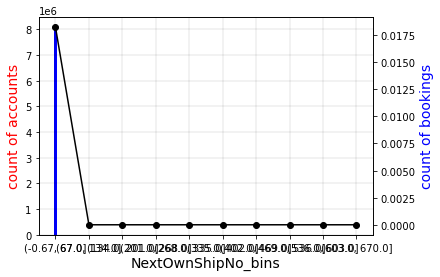

Membership days


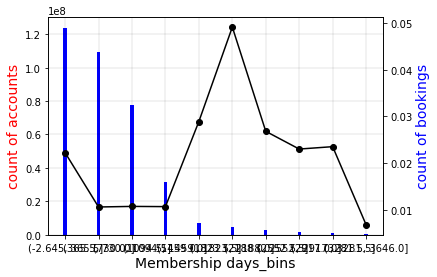

gold_member


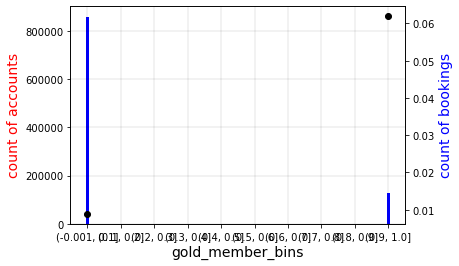

ownershipNo


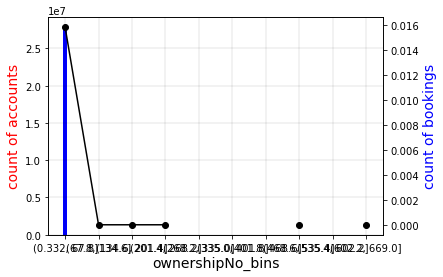

days_to_expiry


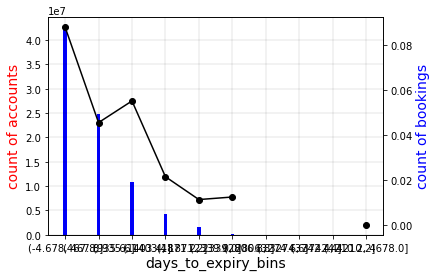

days_since_deposit


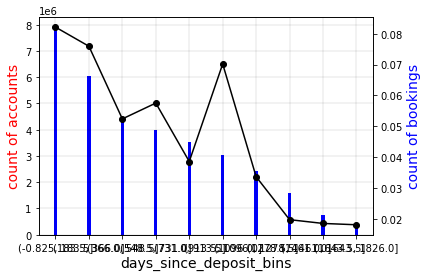

no_bookings_12_months


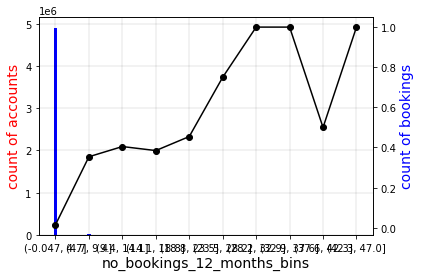

no_cancels_12_months


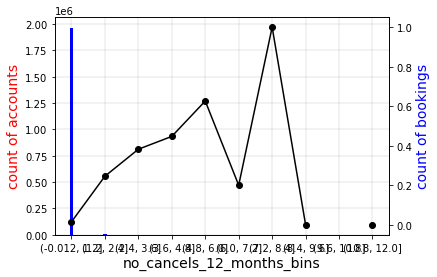

no_bookings_6_months


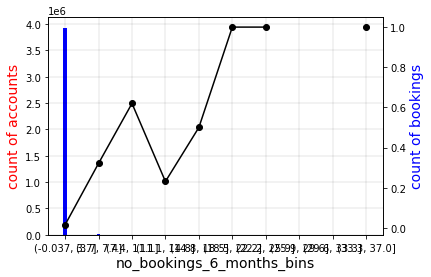

no_cancels_6_months


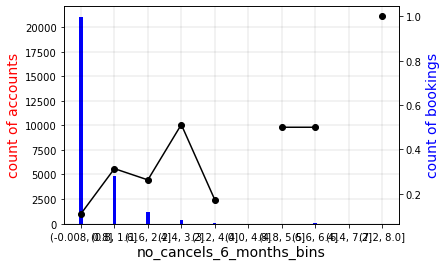

no_searches_in_3_months


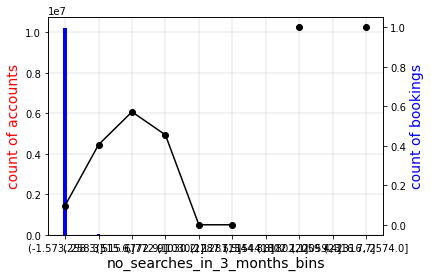

no_requests_in_3_months


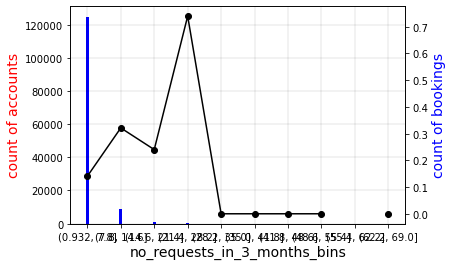

no_searches_in_6_months


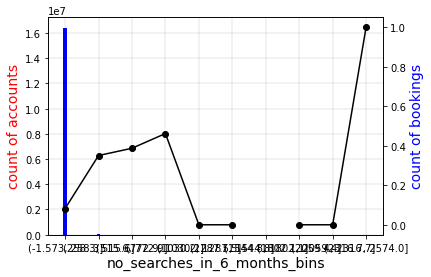

no_requests_in_6_months


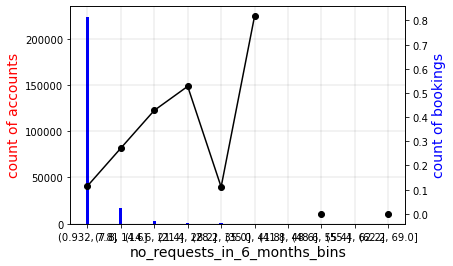

no_searches_in_12_months


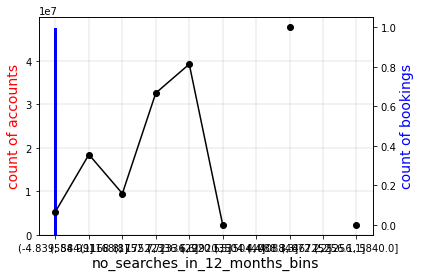

no_requests_in_12_months


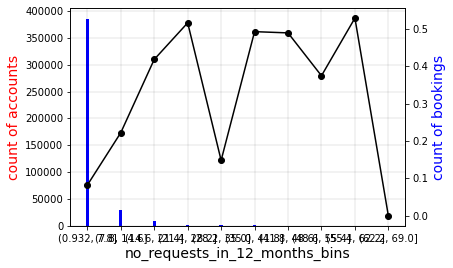

num_offers_cancelled_3_months


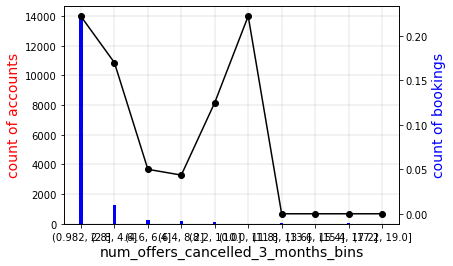

num_offers_cancelled_6_months


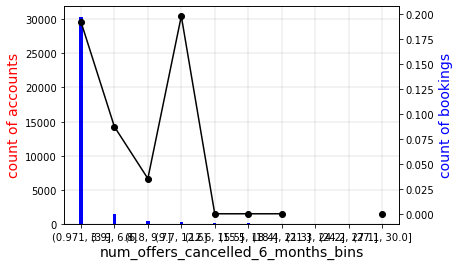

num_offers_cancelled_12_months


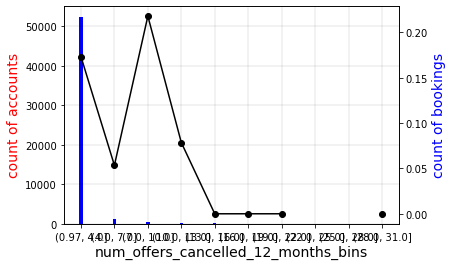

C:\Users\scvch\anaconda4\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regresssion Accuracy:: 83.53%
Logistic regression roc :: 0.80%:
Decision Tree Accuracy:: 85.19%
Decision Tree AUC:: 0.84%
Random Forest Accuracy:: 84.07%
Random Forest AUC:: 0.87%
Xg boost model Accuracy:: 83.92%
Xg boost model Auc:: 0.88%
Epoch 1/20
147/147 [==============================] - 6s 39ms/step - loss: 3.2049 - accuracy: 0.7138 - val_loss: 1.1536 - val_accuracy: 0.7793
Epoch 2/20
147/147 [==============================] - 5s 37ms/step - loss: 0.6203 - accuracy: 0.7669 - val_loss: 0.4591 - val_accuracy: 0.8269
Epoch 3/20
147/147 [==============================] - 5s 36ms/step - loss: 0.5241 - accuracy: 0.7884 - val_loss: 0.3620 - val_accuracy: 0.8583
Epoch 4/20
147/147 [==============================] - 5s 36ms/step - loss: 0.4617 - accuracy: 0.8041 - val_loss: 0.4736 - val_accuracy: 0.7737
Epoch 5/20
147/147 [==============================] - 6s 38ms/step - loss: 0.4488 - accuracy: 0.8065 - val_loss: 0.6026 - val_accuracy: 0.7630
DNN model Auc:: 0.88%
best model is:

C:\Users\scvch\anaconda4\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-14-5bac4c25b05e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_members['gold_member'] = 1
<ipython-input-14-5bac4c25b05e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Credit_new['days_to_expiry'] = Credit_new['ExpiryDate'] - s
<ipython-input-14-5bac4

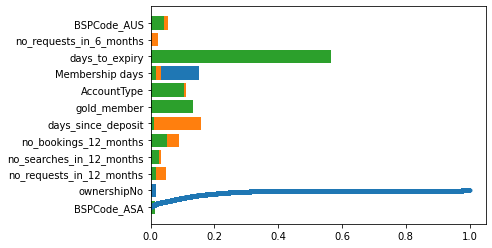

In [85]:
train_start_date = '2020-04-01'
season_length = 3
num_seasons_to_consider = 8
cut_off_probability = 0.9
prediction_start_date = '2022-01-02'

model,X_pred = main(train_start_date,season_length,num_seasons_to_consider,prediction_start_date,cut_off_probability = cut_off_probability,balancing = 1)


if str(type(model)) == "<class 'keras.engine.sequential.Sequential'>":
    y_pred = model.predict(X_pred).ravel()
else:
    y_pred = model.predict_proba(X_pred)[:,1]

X_pred['response'] = y_pred
account_ids = list(X_pred[X_pred['response'] >= cut_off_probability ].index)

#account_ids = pd.DataFrame(account_ids) 
account_ids = list(set(account_ids))


pd.DataFrame(account_ids).to_csv(loc + 'predicted_accounts.csv')


In [90]:

cut_off_probability = 0.99
account_ids = list(X_pred[X_pred['response'] >= cut_off_probability ].index)

#account_ids = pd.DataFrame(account_ids) 
account_ids = list(set(account_ids))


In [91]:
len(set(account_ids))

5897